# Empirical Cross Covariance

Note that the analysis below assumes realizations are independent across time. This is a bad assumption, but should still provide a reasonable approximation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import variogram as vgm
from krige_tools import get_date_range_offset

In [4]:
# Analysis variables
years = [2016, 2019]
tols = [100, 250]
time_lags = [1, 2]
space_lags = np.linspace(0, 3.5e3, 15)

# year = years[1]
# tol = tols[1]
# time_lag = time_lags[0]

# Initial guess for covariance params
vgm_guess = [0.4, 1e3, 0.1]
cross_guess = [1e3, -0.1]

In [5]:
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: 2.5\n len_scale: {p[0]}\n rho: {p[1]}"
    else:
        return f"sigma: {p[0]}\n nu: 2.5\n len_scale: {p[1]}\n nugget: {p[2]}"

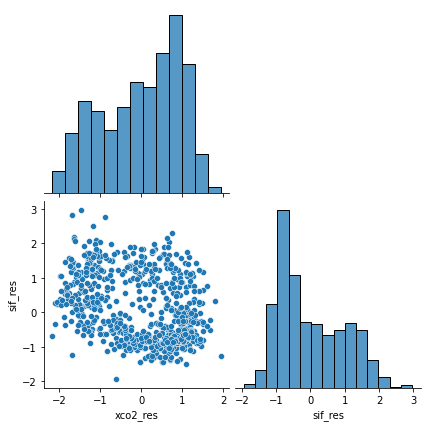

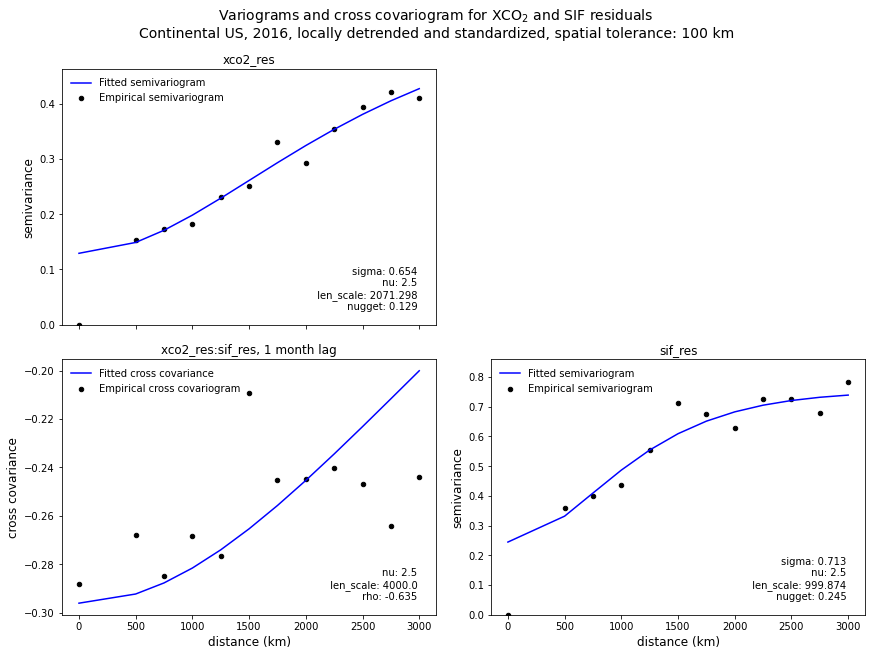

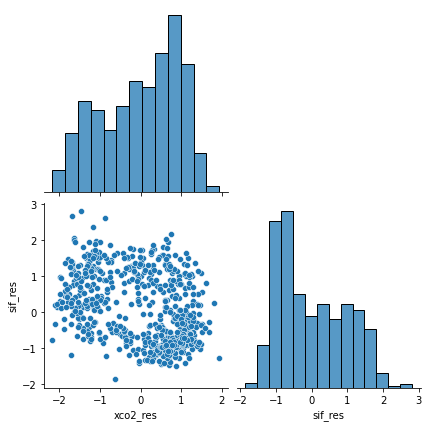

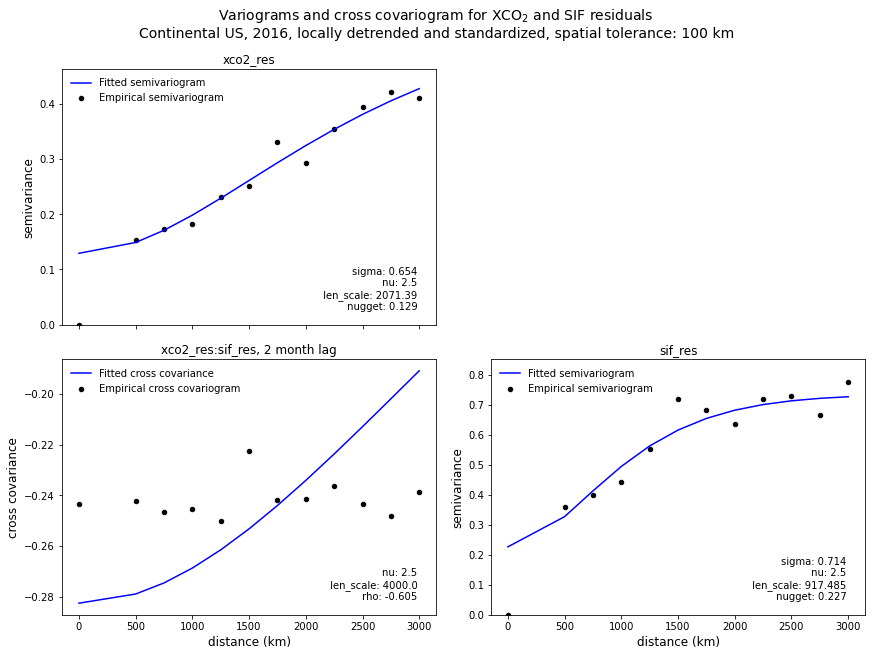

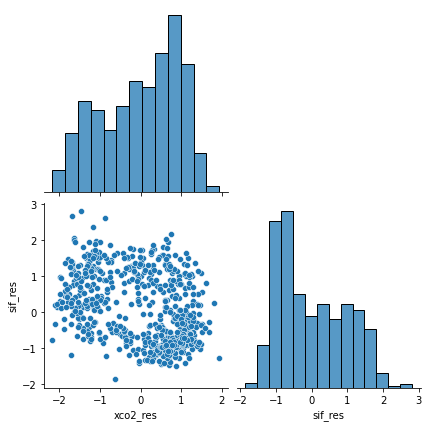

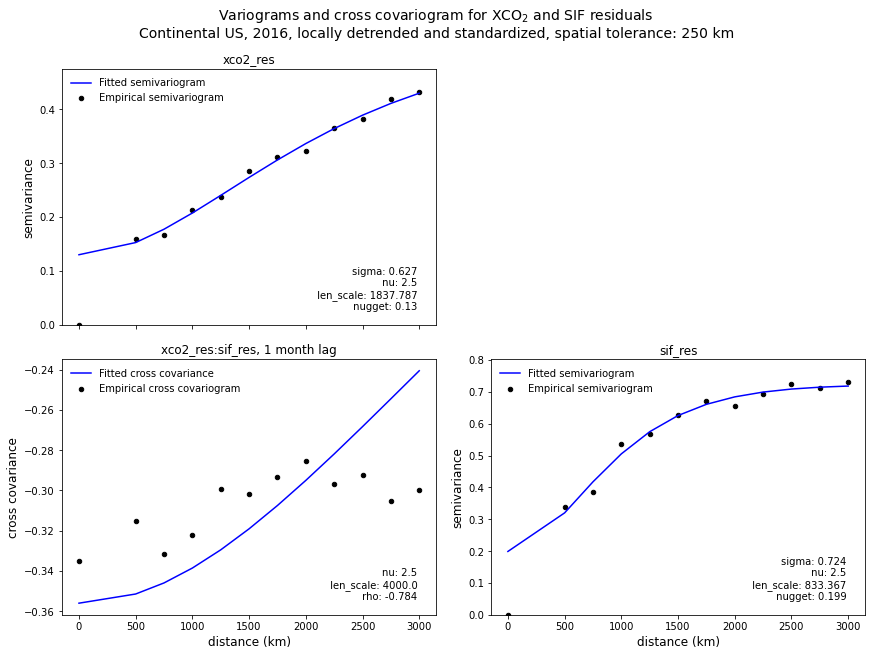

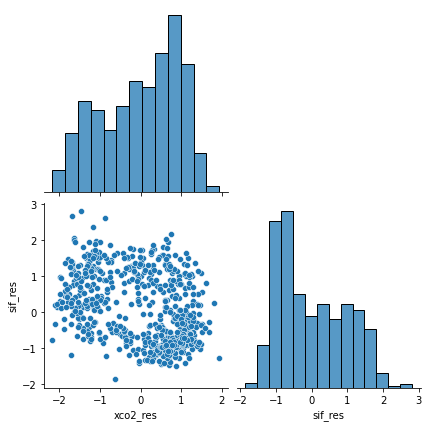

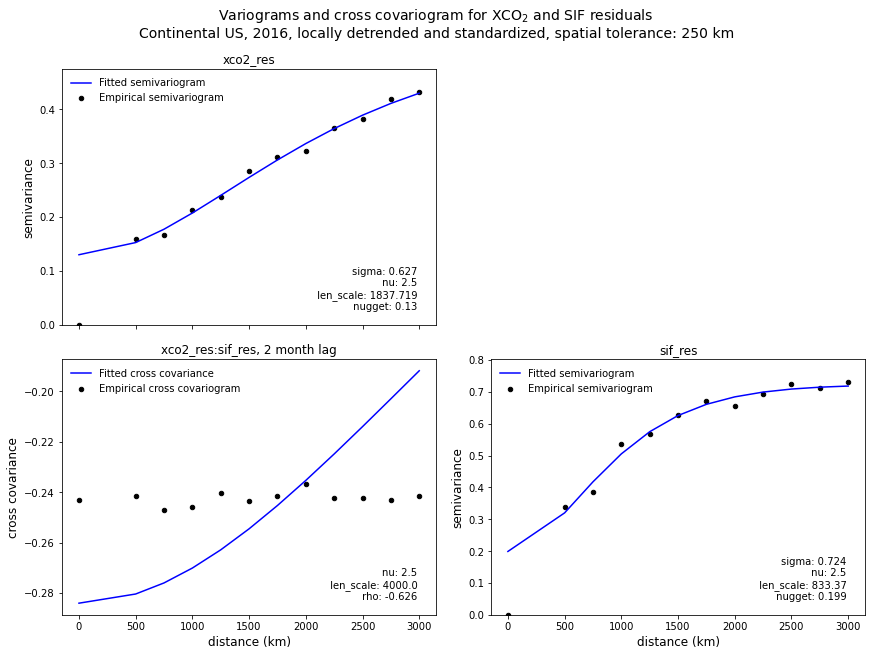

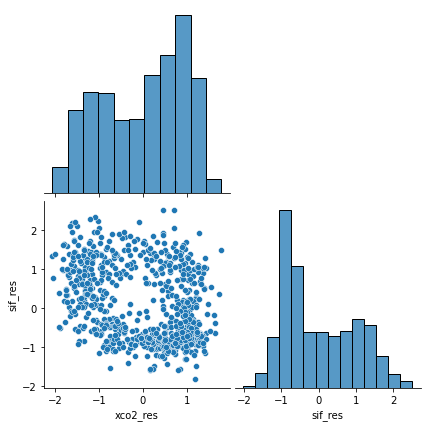

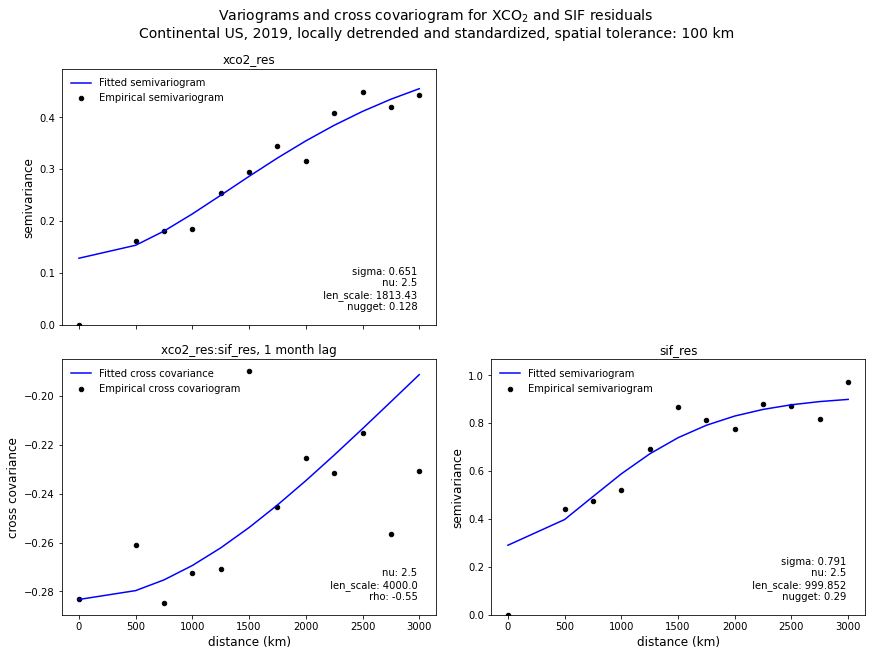

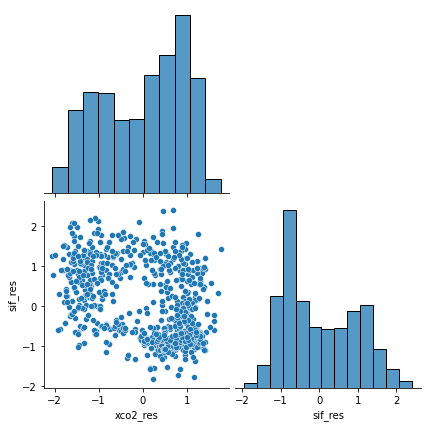

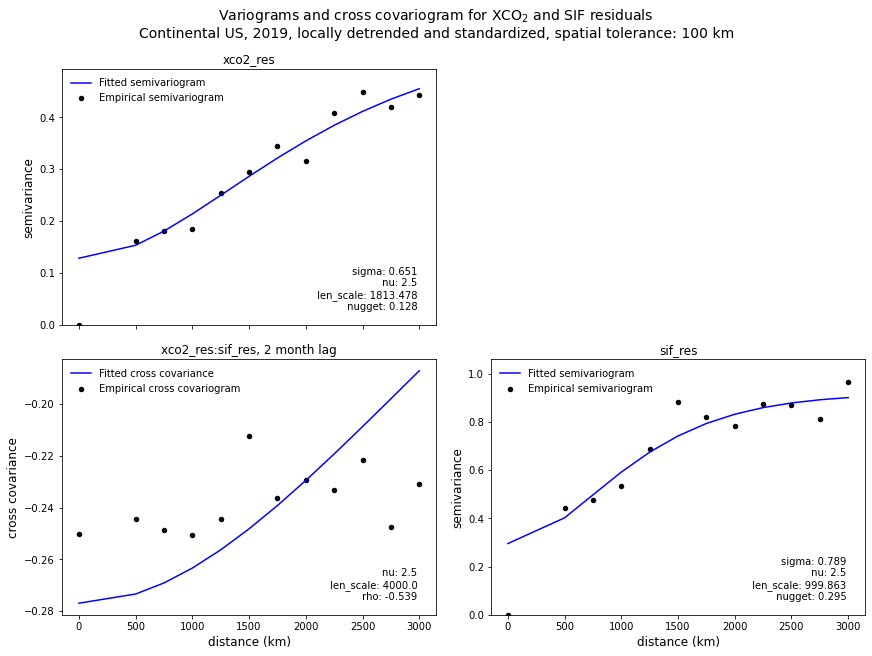

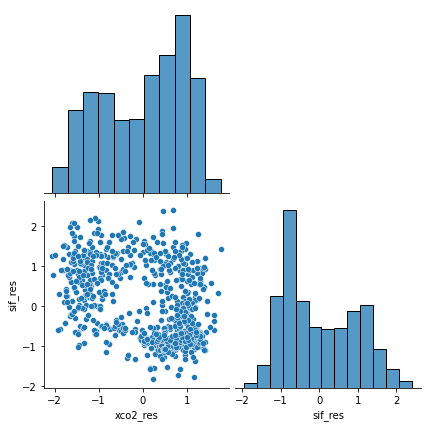

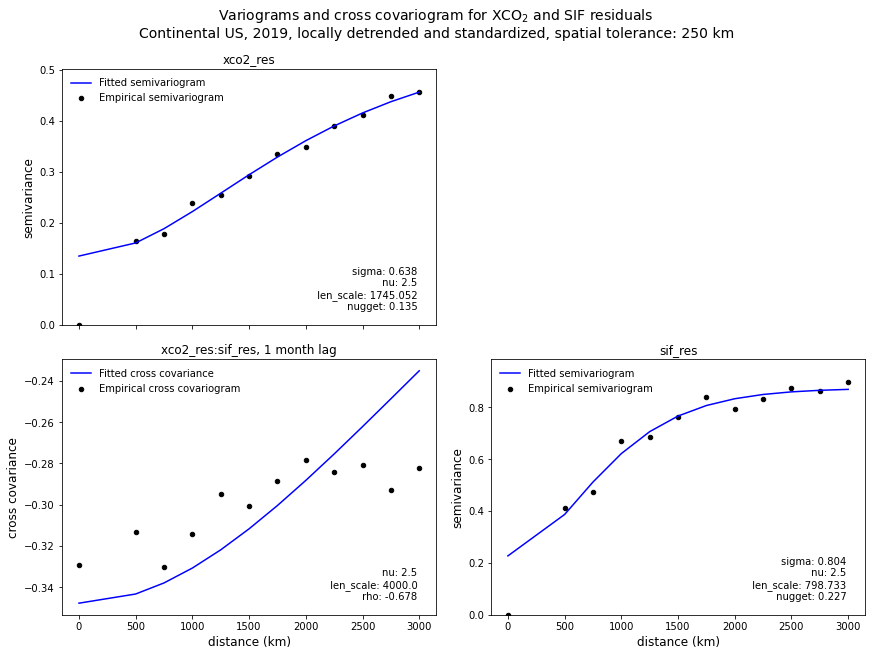

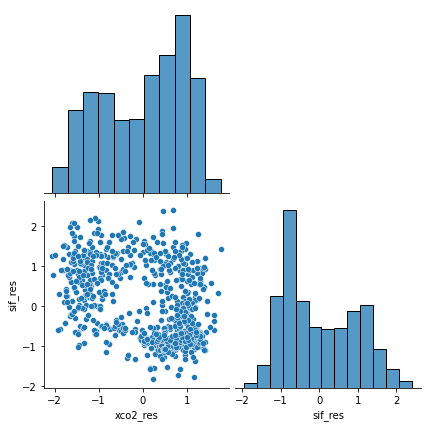

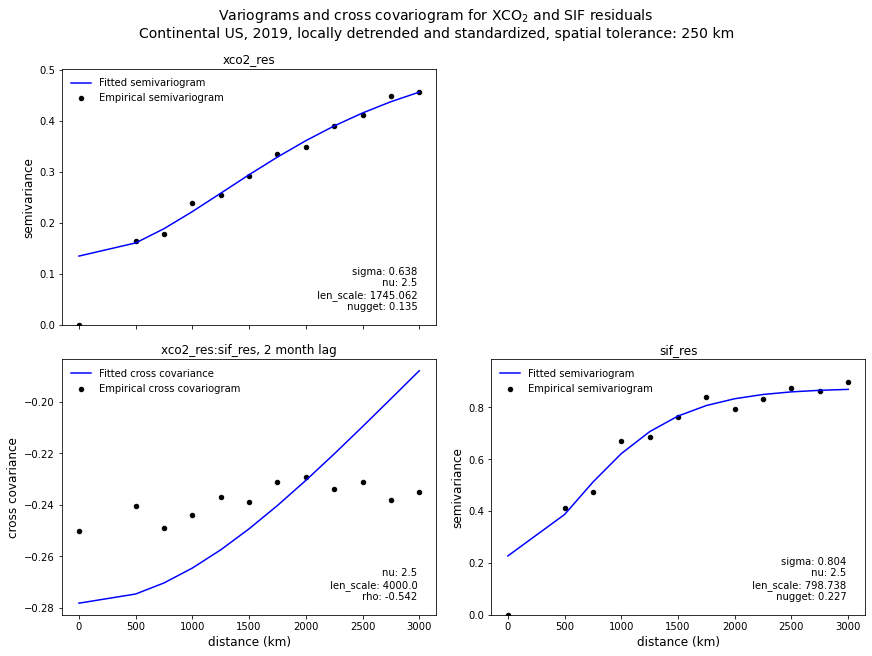

In [7]:
# Make all the plots
for year in years:
    # Get data: detrended 5-degree monthly average, cont. US
    df = pd.read_csv("../data/exp_pro/OCO2_5deg_monthly_conus_detrended.csv")
    
    for tol in tols:
        for time_lag in time_lags:
            # Isolate year and data offset
            columns = ["xco2_res", "sif_res"]
            df = get_date_range_offset(df, columns, year, time_lag)

            # Standardize data locally
            df[columns] = df.groupby(["lon", "lat"])[columns].transform(lambda x: (x - x.mean()) / x.std())

            # Check distributions
            p = sns.pairplot(df, vars=["xco2_res", "sif_res"], corner=True, height=3)
            p.savefig(f"../plots/pairplot_{year}.png")
    
            # Compute empirical variograms and cross covariogram
            df_vgm = vgm.empirical_variogram(
                df,
                ["xco2_res", "sif_res"],
                space_lags,
                tol=tol,
                time_lag=0,
                cross=False,
            )
            df_cov = vgm.empirical_variogram(
                df,
                ["xco2_res", "sif_res"],
                space_lags,
                tol=tol,
                time_lag=time_lag,
                covariogram=True,
            )
            
            # Fit the theoretical Matern covariance model
            xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["xco2_res"], df_vgm["xco2_res_counts"], vgm_guess)
            sif_params, df_vgm["sif_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["sif_res"], df_vgm["sif_res_counts"], vgm_guess)

            sigmas = [xco2_params[0], sif_params[0]]
            cross_params, df_cov["cross_fit"] = vgm.fit_variogram_wls(df_cov["lag"], df_cov["xco2_res:sif_res"], df_cov["xco2_res:sif_res_counts"], cross_guess, sigmas=sigmas)
            
            cols = df_cov.columns[df_cov.columns!="lag"]
            fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
            ax[0, 1].axis("off")

            df_vgm.plot(x="lag", y="xco2_res", kind="scatter", color="black", ax=ax[0, 0], label="Empirical semivariogram")
            df_vgm.plot(x="lag", y="xco2_fit", kind="line", color="blue", ax=ax[0, 0], label="Fitted semivariogram")
            lim = df_vgm["xco2_res"].max()
            ax[0, 0].set_title("xco2_res", fontsize=12)
            ax[0, 0].set_ylabel("semivariance", fontsize=12)
            ax[0, 0].set_ylim([0, lim+0.1*lim])
            ax[0, 0].text(0.95, 0.05, param_labels(xco2_params), transform=ax[0, 0].transAxes, ha="right", va="bottom")
            ax[0, 0].legend(frameon=False)

            df_vgm.plot(x="lag", y="sif_res", kind="scatter", color="black", ax=ax[1, 1], label="Empirical semivariogram")
            df_vgm.plot(x="lag", y="sif_fit", kind="line", color="blue", ax=ax[1, 1], label="Fitted semivariogram")
            lim = df_vgm["sif_res"].max()
            ax[1, 1].set_title("sif_res", fontsize=12)
            ax[1, 1].set_ylabel("semivariance", fontsize=12)
            ax[1, 1].set_xlabel("distance (km)", fontsize=12)
            ax[1, 1].set_ylim([0, lim+0.1*lim])
            ax[1, 1].text(0.95, 0.05, param_labels(sif_params), transform=ax[1, 1].transAxes, ha="right", va="bottom")
            ax[1, 1].legend(frameon=False)

            df_cov.plot(x="lag", y="xco2_res:sif_res", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross covariogram")
            df_cov.plot(x="lag", y="cross_fit", kind="line", color="blue", ax=ax[1, 0], label="Fitted cross covariance")
            ax[1, 0].set_title("xco2_res:sif_res" + f", {time_lag} month lag", fontsize=12)
            ax[1, 0].set_ylabel("cross covariance", fontsize=12)
            ax[1, 0].set_xlabel("distance (km)", fontsize=12)
            ax[1, 0].text(0.95, 0.05, param_labels(cross_params, cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
            ax[1, 0].legend(loc="upper left", frameon=False)

            fig.suptitle("Variograms and cross covariogram for XCO$_2$ and SIF residuals\n"+
                         f"Continental US, {year}, locally detrended and standardized, spatial tolerance: {tol} km", fontsize=14)

            fig.savefig(f"../plots/vario_analysis_conUS_{year}_{time_lag}M_{tol}km.png", dpi=100);

In [6]:
# Get data: detrended 5-degree monthly average, cont. US
df = pd.read_csv("../data/exp_pro/OCO2_5deg_monthly_conus_detrended.csv")

time_lag = 1

# Isolate year and data offset
columns = ["xco2_res", "sif_res"]
df = get_date_range_offset(df, columns, 2019, time_lag)

# Standardize data locally
df[columns] = df.groupby(["lon", "lat"])[columns].transform(lambda x: (x - x.mean()) / x.std())

df

,lat,lon,time,xco2_res,sif_res
0,12.5,-92.5,2019-01-01,-0.165133,-0.548626
1,12.5,-92.5,2019-02-01,0.325714,-1.055014
2,12.5,-92.5,2019-03-01,0.840372,-1.564703
3,12.5,-92.5,2019-04-01,1.615102,-0.172724
4,12.5,-92.5,2019-05-01,1.042413,0.232612
...,...,...,...,...,...
1009,47.5,-87.5,2018-12-01,NaN,-0.493547
1010,47.5,-82.5,2018-12-01,NaN,-0.866795
1011,47.5,-77.5,2018-12-01,NaN,-0.731766
1012,47.5,-72.5,2018-12-01,NaN,-0.763756


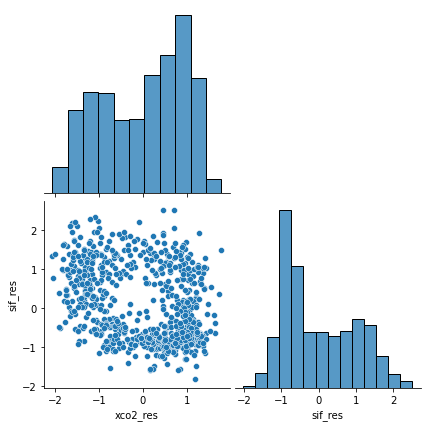

In [7]:
# Check distributions
p = sns.pairplot(df, vars=["xco2_res", "sif_res"], corner=True, height=3)
p.savefig(f"../plots/pairplot_{year}.png")

In [40]:
# Compute empirical variograms and cross covariogram
tol = 250
space_lags = np.linspace(0, 3.5e3, 15)
# tol = 250
# space_lags = np.arange(0, 3.5e3, tol*2)

df_vgm = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=0,
    cross=False,
)
df_cov = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=time_lag,
    covariogram=True,
)

In [41]:
df_cov

,lag,xco2_res,xco2_res_counts,sif_res,sif_res_counts,xco2_res:sif_res,xco2_res:sif_res_counts
0,0.0,0.726492,1394.0,0.622730,1632.0,-0.283189,1463.0
1,500.0,0.736068,7704.0,0.577955,8936.0,-0.263161,8264.0
2,750.0,0.731780,9378.0,0.558148,11292.0,-0.281947,10214.0
3,1000.0,0.712670,12536.0,0.490469,15634.0,-0.266915,13926.0
4,1250.0,0.709156,14548.0,0.483258,17402.0,-0.245344,15871.0
5,1500.0,0.696626,13866.0,0.453333,16654.0,-0.251510,15153.0
6,1750.0,0.683604,14772.0,0.421726,18200.0,-0.239596,16362.0
7,2000.0,0.676817,13514.0,0.435238,16394.0,-0.227880,14861.0
8,2250.0,0.659000,15294.0,0.422377,18978.0,-0.234510,17013.0
9,2500.0,0.653089,13758.0,0.403041,17398.0,-0.230270,15457.0


In [42]:
# Fit the theoretical Matern covariance model
vgm_guess = [0.4, 1e3, 0.1]
cross_guess = [2e3, -0.5]

# xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["xco2_res"], vgm_guess)
# sif_params, df_vgm["sif_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["sif_res"], vgm_guess)
# cross_params, df_cov["cross_fit"] = vgm.fit_variogram(df_cov["lag"], df_cov["xco2_res:sif_res"], cross_guess, cross=True)

xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["xco2_res"], df_vgm["xco2_res_counts"], vgm_guess)
sif_params, df_vgm["sif_fit"] = vgm.fit_variogram_wls(df_vgm["lag"], df_vgm["sif_res"], df_vgm["sif_res_counts"], vgm_guess)

sigmas = [xco2_params[0], sif_params[0]]
cross_params, df_cov["cross_fit"] = vgm.fit_variogram_wls(df_cov["lag"], df_cov["xco2_res:sif_res"], df_cov["xco2_res:sif_res_counts"], cross_guess, sigmas=sigmas)
# res = vgm.fit_variogram_wls(df_cov["lag"], df_cov["xco2_res:sif_res"], df_cov["xco2_res:sif_res_counts"], cross_guess, cross=True)

Text(0.5, 0.98, 'Variograms and cross covariogram for XCO$_2$ and SIF residuals\nContinental US, 2019, locally detrended and standardized, spatial tolerance: 250 km')

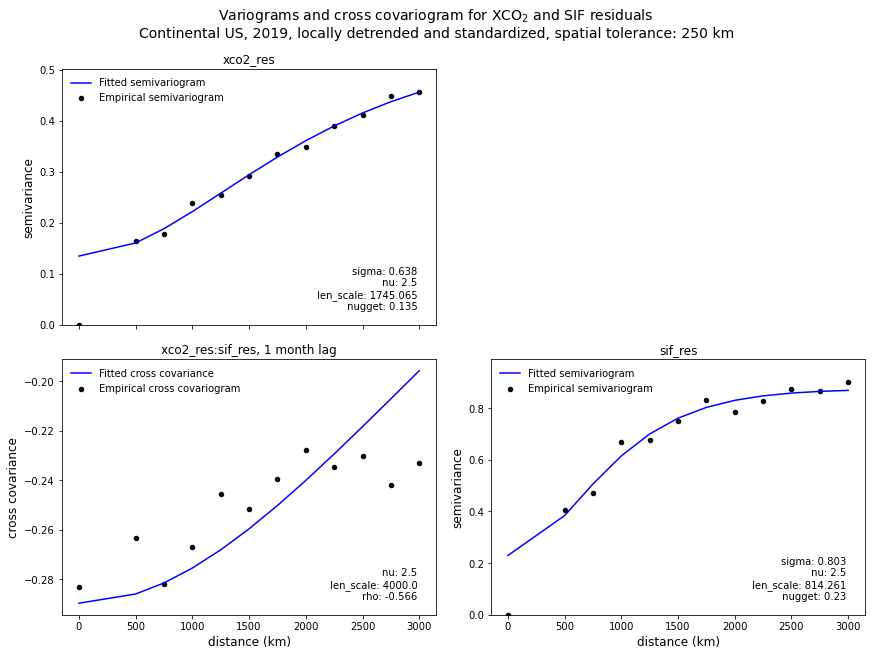

In [43]:
cols = df_cov.columns[df_cov.columns!="lag"]
fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")

df_vgm.plot(x="lag", y="xco2_res", kind="scatter", color="black", ax=ax[0, 0], label="Empirical semivariogram")
df_vgm.plot(x="lag", y="xco2_fit", kind="line", color="blue", ax=ax[0, 0], label="Fitted semivariogram")
lim = df_vgm["xco2_res"].max()
ax[0, 0].set_title("xco2_res", fontsize=12)
ax[0, 0].set_ylabel("semivariance", fontsize=12)
ax[0, 0].set_ylim([0, lim+0.1*lim])
ax[0, 0].text(0.95, 0.05, param_labels(xco2_params), transform=ax[0, 0].transAxes, ha="right", va="bottom")
ax[0, 0].legend(frameon=False)

df_vgm.plot(x="lag", y="sif_res", kind="scatter", color="black", ax=ax[1, 1], label="Empirical semivariogram")
df_vgm.plot(x="lag", y="sif_fit", kind="line", color="blue", ax=ax[1, 1], label="Fitted semivariogram")
lim = df_vgm["sif_res"].max()
ax[1, 1].set_title("sif_res", fontsize=12)
ax[1, 1].set_ylabel("semivariance", fontsize=12)
ax[1, 1].set_xlabel("distance (km)", fontsize=12)
ax[1, 1].set_ylim([0, lim+0.1*lim])
ax[1, 1].text(0.95, 0.05, param_labels(sif_params), transform=ax[1, 1].transAxes, ha="right", va="bottom")
ax[1, 1].legend(frameon=False)

df_cov.plot(x="lag", y="xco2_res:sif_res", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross covariogram")
df_cov.plot(x="lag", y="cross_fit", kind="line", color="blue", ax=ax[1, 0], label="Fitted cross covariance")
ax[1, 0].set_title("xco2_res:sif_res" + f", {time_lag} month lag", fontsize=12)
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("distance (km)", fontsize=12)
ax[1, 0].text(0.95, 0.05, param_labels(cross_params, cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left", frameon=False)

fig.suptitle("Variograms and cross covariogram for XCO$_2$ and SIF residuals\n"+
             f"Continental US, {year}, locally detrended and standardized, spatial tolerance: {tol} km", fontsize=14)

# fig.savefig(f"../plots/vario_analysis_conUS_{year}_{time_lag}M_{tol}km.png", dpi=100)